purpose: run functional enrichment and heirarchical clustering and seed gene fractions
borrowed from rat bmi network2
need to decide parameters
do NOT  fuck with the network data intake functions here i spent so long fixing them.

# set-up

In [1]:
#this is way too many fucking packages

In [ ]:
import cdapsutil
import pandas as pd
import ndex2
# load required libraries
import os
import sys
import ndex2
from getpass import getpass
import cdapsutil
import pandas as pd
#import mygene
#mg = mygene.MyGeneInfo()
from gprofiler import GProfiler
gp = GProfiler("MyToolName/0.1")

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection

import statistics as stat

In [ ]:
import os
os.chdir('/tscc/projects/ps-palmer/brittany/ddot')
import ddot
from netcoloc import netprop_zscore, netprop, network_colocalization, validation
os.chdir('/tscc/projects/ps-palmer/brittany/rare_common_alcohol/rare_common_alcohol_comparison/notebooks/')
from rca_functions import *
os.chdir('/tscc/projects/ps-palmer/brittany/SUD_cross_species/scripts')
from network_functions import *
from network_validation_functions import *
from plotting_functions import *
os.chdir('/tscc/projects/ps-palmer/brittany/CrossSpeciesBMI/')
from analysis_functions import get_seed_gene_fractions
os.chdir('/tscc/projects/ps-palmer/brittany/SUD_cross_species/')

In [ ]:
os.chdir('/tscc/projects/ps-palmer/brittany/SUD_cross_species/')

In [ ]:
#create a file called environ_ndex_meta.py where you save variables 'ndex_user' and 'ndex_password'
#otherwise will prompt you to define those within the notebooks
if os.path.isfile('../environ_ndex_meta.py'):
    print ('NDEx credentials imported from meta file')
    sys.path.insert(1, '../')
    from environ_ndex_meta import *
    sys.path.pop(1)
else:
    # Prompt the user for a username
    ndex_user = input("Enter your NDEx username: ")
    # Prompt the user for a password
    ndex_password = input("Enter your NDEx password: ")

In [5]:
import_network=False

# Interactome Set-up

pcnet2- versions 
from wright et al. 2024 preprint:
PCNet 2.0= best-performing ranked composite (top 15 interactomes, 3.85M interactions)
PCNet 2.1= top 8 interactomes, 1.75M interactions
PCNet 2.2= top 10 co-citation-free interactomes, 3.32M interactions 

In [6]:
interactome_name='PCNet2.0'

In [7]:
interactome=import_interactome(UUIDs=UUIDs, interactome_name=interactome_name)
all_nodes=list(interactome.nodes())

PCNet2.0
Name: PCNet 2.0
Nodes: 19267
Edges: 3852119
Node Attributes: 19267
Edge Attributes: 19260595

number of nodes:
19267

number of edges:
3852119


In [8]:
#all_nodes=list(pd.read_csv('PCNET2.0_allNodes.tsv',header=None)[0])

# import NPS scores and seed genes

In [9]:
seed_dict=import_seed_dict(mag_dir,file_dict,bonf_dict,gene_col_dict,all_nodes)
seed_dict.keys()

dict_keys(['loco_bonf', 'loco_top500', 'loco_FDR', 'loco_gsem_bonf', 'loco_gsem_top500', 'loco_gsem_FDR', 'ext_bonf', 'ext_top500', 'ext_FDR', 'ext_st22', 'loco_mega_fus_naac_bonf', 'loco_mega_fus_naac_top500', 'loco_mega_fus_naac_FDR', 'ext_fus_naac_bonf', 'ext_fus_naac_top500', 'ext_fus_naac_FDR', 'loco_final_cf_bonf', 'loco_final_cf_top500', 'loco_final_cf_FDR', 'loco_final_mega_bonf', 'loco_final_mega_top500', 'loco_final_mega_FDR'])

In [10]:
#dictionary of human control traits
ctrl_dict={}
ctrl_traits=['facial_hair', 'age_smkinit', 'antisoc', 'friend_sat', 'hr', 'infant_bw', 'LDL', 'maternal_smok', 'townsend', 'age_menarche', 'neurot','addict-rf']
for t in ctrl_traits:
    ctrl_dict[t]=pd.read_csv('gwas_ctrl_hm/magma/seed_genes/'+t+'_annot.tsv',sep='\t')
for t in ctrl_traits:
    seed_dict[t+'_FDR']=(set(ctrl_dict[t][ctrl_dict[t]['Q']<0.05]['GENE']))
    seed_dict[t+'_bonf']=(set(ctrl_dict[t][ctrl_dict[t]['P']<0.05/len(ctrl_dict[t])]['GENE']))
    seed_dict[t+'_top500']=set(ctrl_dict[t][(ctrl_dict[t]['GENE'].isin(all_nodes))].nsmallest(500,'P')['GENE'])

In [11]:
NPS_dict,NPS_dict_series=import_NPS_scores(seed_dict,UUIDs)

# define dataset

In [12]:
#modify for correct genesets
cut_r= 'FDR'
cut_h='top500'
trait_r='loco_final_cf'
trait_h='ext'
snp2gene='MAGMA'

label_h,label_r,seed_h,seed_r,NPS_h,NPS_r,NPS=return_analysis_datasets(trait_r,cut_r,trait_h,cut_h,seed_dict,NPS_dict,interactome_name)

In [13]:
name=label_r+'_'+label_h+'_'+interactome_name+'_'+snp2gene

In [14]:
net=network_colocalization.calculate_network_overlap_subgraph(
    interactome, pd.Series(NPS_r['z']), pd.Series(NPS_h['z']), cut_comb, cut_single, cut_single)
net=format_network(net, label_r, label_h, seed_r , seed_h, NPS_r['z'], NPS_h['z'])
net_cx = ndex2.create_nice_cx_from_networkx(net)
net_cx.set_name(name)

# import system map

In [17]:
if import_network:
    hier=import_interactome(UUID='9826150f-f9f9-11ef-b81d-005056ae3c32',ndex_user=ndex_user,ndex_password=ndex_password)
    hier_net = ndex2.create_nice_cx_from_networkx(net)
    #net_cx.set_name(name)
    hier_df = pd.DataFrame.from_dict(dict(hier.nodes(data=True)), orient="index")

# run hierarchical clustering

In [18]:
cd = cdapsutil.CommunityDetection()

In [21]:
algorithm='hidefv1.1beta'
#hier_net = cd.run_community_detection(net_cx, algorithm='hidefv1.1beta',arguments={'--maxres':'10'})
hier_net = cd.run_community_detection(net_cx, algorithm=algorithm,arguments={'--maxres':'10'})

In [22]:
print('Hierarchy name: ' + str(hier_net.get_name()))
print('# nodes: ' + str(len(hier_net.get_nodes())))
print('# edges: ' + str(len(hier_net.get_edges())))

Hierarchy name: hidefv1.1beta_(none)_loco_final_cf_FDR_ext_top500_PCNet2.0_MAGMA
# nodes: 47
# edges: 49


In [23]:
hier = hier_net.to_networkx()
#hier = nx.relabel_nodes(hier, nx.get_node_attributes(hier, 'name'))

In [24]:
hier_df = pd.DataFrame.from_dict(dict(hier.nodes(data=True)), orient="index")

# Get Community Stats

In [26]:
def get_seed_gene_fractions(hier_df, seeds1, seeds2, seed1_name='h_seed', seed2_name='r_seed'):
    """Assess the number of genes in each community that were seed genes from the orginal inputs

    Args:
        hier_df (pd.DataFrame): The hierarchy information of gene communities
        seeds1 (list): List of genes from input 1
        seeds2 (list): List of genes from input 2
        seed1_name (str, optional): Name to give the seed genes from input 1. Defaults to 'h_seed'.
        seed2_name (str, optional): Name to give the seed genes from input 2. Defaults to 'r_seed'.

    Returns:
        pd.DataFrame: The fraction of genes in each community that are seeds in both seeds1 and seeds2, the fraction just in seeds1, the fraction just in seeds2
    """
    hier_df["CD_MemberList"] = hier_df.CD_MemberList.apply(lambda x: x if type(x)==list else x.split(" "))
    comm_genes = hier_df.explode("CD_MemberList")
    comm_genes[f'{seed1_name}_ratio'] = [1 if x in seeds1 else 0 for x in comm_genes.CD_MemberList]
    comm_genes[f'{seed2_name}_ratio'] = [1 if x in seeds2 else 0 for x in comm_genes.CD_MemberList]
    comm_genes["seed_hr_ratio"] = comm_genes.apply(lambda x: x[f'{seed1_name}_ratio'] * x[f'{seed2_name}_ratio'], axis=1)
    a = comm_genes.groupby(level=0).seed_hr_ratio.sum()
    b = comm_genes[comm_genes.seed_hr_ratio != 1].groupby(level=0)[f'{seed1_name}_ratio'].sum()
    c = comm_genes[comm_genes.seed_hr_ratio != 1].groupby(level=0)[f'{seed2_name}_ratio'].sum()
    d = comm_genes.groupby(level=0).CD_MemberList.count()
    counts = pd.concat([a,b,c,d], axis=1)
    counts["network_ratio"] = counts.apply(lambda x: x.CD_MemberList - x.seed_hr_ratio - x[f'{seed1_name}_ratio'] - x[f'{seed2_name}_ratio'], axis=1)
    fracs = counts.div(counts.CD_MemberList, axis=0)    
    return fracs

In [27]:
def get_gene_NPS_scores(hier_df,NPS_r,NPS_h,cut_r=1.5,cut_h=1.5,cut_hr=3):
    hier_df["CD_MemberList"] = hier_df.CD_MemberList.apply(lambda x: x if type(x)==list else x.split(" "))
    comm_genes = hier_df.explode("CD_MemberList")
    comm_genes['NPSr']=comm_genes.CD_MemberList.apply(lambda x: NPS_r.z[x])
    comm_genes['NPSh']=comm_genes.CD_MemberList.apply(lambda x: NPS_h.z[x])
    comm_genes['NPShr']=comm_genes['NPSh']*comm_genes['NPSr']
    
    NPS=NPS_r.merge(NPS_h,left_index=True,right_index=True)
    NPS.columns=['NPSr','NPSh']
    NPS['NPShr']=NPS.NPSh*NPS.NPSr
    netgenes=list(NPS[(NPS.NPSh>cut_h)&(NPS.NPSr>cut_r)&(NPS.NPShr>cut_hr)].index)
    
    #median
    medr=comm_genes.groupby(level=0)['NPSr'].median()
    medh=comm_genes.groupby(level=0)['NPSh'].median()
    medhr=comm_genes.groupby(level=0)['NPShr'].median()
    
    #median_normalized
    medr_n=comm_genes.groupby(level=0)['NPSr'].median()/NPS.NPSr[netgenes].median()
    medh_n=comm_genes.groupby(level=0)['NPSh'].median()/NPS.NPSh[netgenes].median()
    medhr_n=comm_genes.groupby(level=0)['NPShr'].median()/NPS.NPShr[netgenes].median()
    
    
    meanr=comm_genes.groupby(level=0)['NPSr'].mean()
    meanh=comm_genes.groupby(level=0)['NPSh'].mean()
    meanhr=comm_genes.groupby(level=0)['NPShr'].mean()
    
    #mean_normalized
    meanr_n=comm_genes.groupby(level=0)['NPSr'].mean()/NPS.NPSr[netgenes].mean()
    meanh_n=comm_genes.groupby(level=0)['NPSh'].mean()/NPS.NPSh[netgenes].mean()
    meanhr_n=comm_genes.groupby(level=0)['NPShr'].mean()/NPS.NPShr[netgenes].mean()
    
    c = pd.concat([medr,medh,medhr,medr_n,medh_n,medhr_n,meanr,meanh,meanhr,meanr_n,meanh_n,meanhr_n], axis=1)
    c.columns=['medr','medh','medhr','medr_n','medh_n','medhr_n','meanr','meanh','meanhr','meanr_n','meanh_n','meanhr_n']
    return c

## Get fractions of seed genes

In [28]:
seed_fractions = get_seed_gene_fractions(hier_df, seed_h, seed_r)
seed_fractions=seed_fractions.drop('CD_MemberList',axis=1)

In [29]:
#check that all of the ratios add up to 1
set(seed_fractions.seed_hr_ratio+seed_fractions.h_seed_ratio+seed_fractions.r_seed_ratio+seed_fractions.network_ratio)

{1.0}

In [30]:
seed_fractions.to_csv(f"network_analysis/{name}_{algorithm}_hierarchy_community_seed_fractions.tsv", index=True, header=True, sep= "\t")

## Get NPS stats

In [31]:
nps_stats=get_gene_NPS_scores(hier_df,NPS_r,NPS_h)

In [32]:
nps_stats.to_csv(f"network_analysis/{name}_{algorithm}_hierarchy_community_nps_stats.tsv", index=True, header=True, sep= "\t")

## plot NPS stats

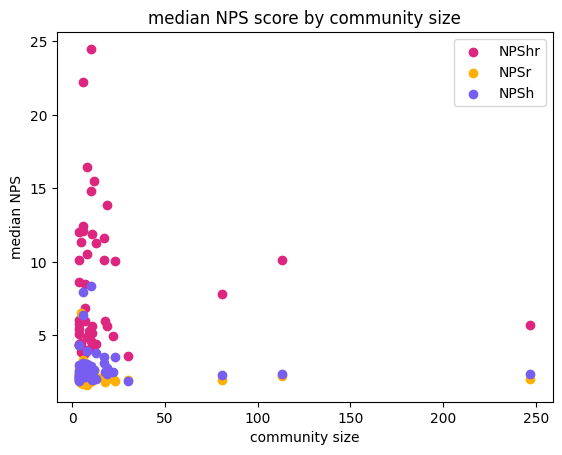

In [34]:
plt.scatter(x=hier_df.CD_MemberList_Size.astype(int),y=nps_stats.medhr,color=colour_dict['shared'],label='NPShr')
plt.scatter(x=hier_df.CD_MemberList_Size.astype(int),y=nps_stats.medr,color=colour_dict[trait_r],label='NPSr')
plt.scatter(x=hier_df.CD_MemberList_Size.astype(int),y=nps_stats.medh,color=colour_dict[trait_h],label='NPSh')
plt.title('median NPS score by community size')
plt.xlabel('community size')
plt.ylabel('median NPS')
plt.legend()

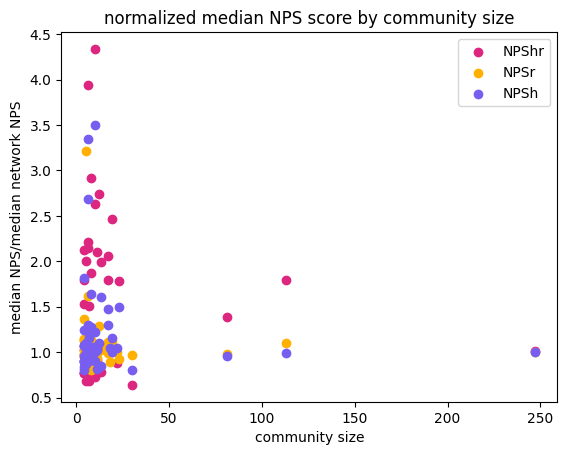

In [35]:
plt.scatter(x=hier_df.CD_MemberList_Size.astype(int),y=nps_stats.medhr_n,color=colour_dict['shared'],label='NPShr')
plt.scatter(x=hier_df.CD_MemberList_Size.astype(int),y=nps_stats.medr_n,color=colour_dict[trait_r],label='NPSr')
plt.scatter(x=hier_df.CD_MemberList_Size.astype(int),y=nps_stats.medh_n,color=colour_dict[trait_h],label='NPSh')
plt.title('normalized median NPS score by community size')
plt.xlabel('community size')
plt.ylabel('median NPS/median network NPS')
plt.legend()

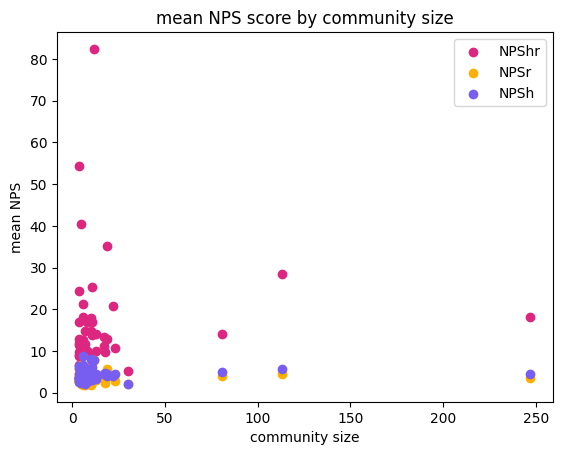

In [36]:
plt.scatter(x=hier_df.CD_MemberList_Size.astype(int),y=nps_stats.meanhr,color=colour_dict['shared'],label='NPShr')
plt.scatter(x=hier_df.CD_MemberList_Size.astype(int),y=nps_stats.meanr,color=colour_dict[trait_r],label='NPSr')
plt.scatter(x=hier_df.CD_MemberList_Size.astype(int),y=nps_stats.meanh,color=colour_dict[trait_h],label='NPSh')
plt.title('mean NPS score by community size')
plt.xlabel('community size')
plt.ylabel('mean NPS')
plt.legend()

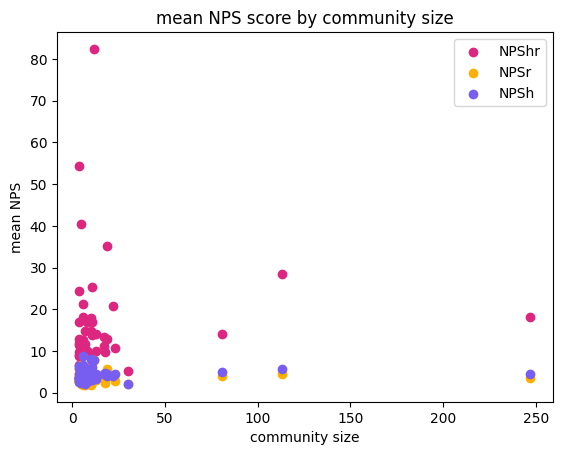

In [37]:
plt.scatter(x=hier_df.CD_MemberList_Size.astype(int),y=nps_stats.meanhr,color=colour_dict['shared'],label='NPShr')
plt.scatter(x=hier_df.CD_MemberList_Size.astype(int),y=nps_stats.meanr,color=colour_dict[trait_r],label='NPSr')
plt.scatter(x=hier_df.CD_MemberList_Size.astype(int),y=nps_stats.meanh,color=colour_dict[trait_h],label='NPSh')
plt.title('mean NPS score by community size')
plt.xlabel('community size')
plt.ylabel('mean NPS')
plt.legend()

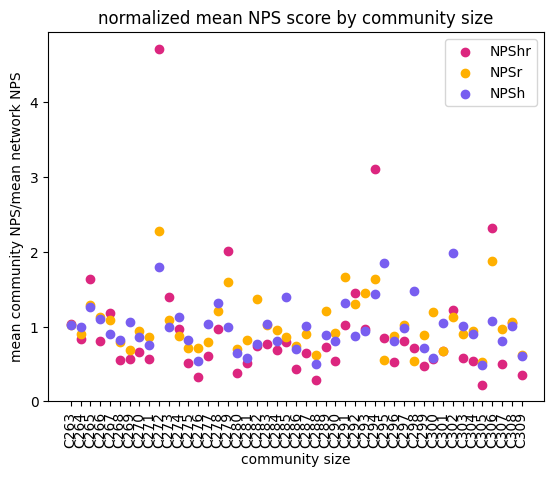

In [38]:
plt.scatter(x=nps_stats.index,y=nps_stats.meanhr_n,color=colour_dict['shared'],label='NPShr')
plt.scatter(x=nps_stats.index,y=nps_stats.meanr_n,color=colour_dict[trait_r],label='NPSr')
plt.scatter(x=nps_stats.index,y=nps_stats.meanh_n,color=colour_dict[trait_h],label='NPSh')
plt.title('normalized mean NPS score by community size')
plt.xlabel('community size')
plt.xticks(rotation=90)
plt.ylabel('mean community NPS/mean network NPS')
plt.legend()

# get GO annotations

In [39]:
def filter_go_annotations(go_df, term_min=10, term_max=5000, p_th=1e-5, min_intersection=3):
    """Filters available annotations for a community based on specificity and significance.
    Args:
        go_df (pandas.DataFrame): All available significant GO terms for each community
        term_min (int, optional):   The minimum size of a term to keep. Defaults to 50.
        term_max (int, optional): The maximum size of a term to keep. Defaults to 1000.
        p_th (float, optional): The significance threshold. Defaults to 1e-4.
        min_intersection (int, optional): Minimum number of community terms annotated to the GO term. Defaults to 3.

    Returns:
        pandas.DataFrame: A filter dataframe of GO annotations per community, sorted by sum of precision and recall.
    """
    go_df = go_df[(go_df['term_size'] <= term_max) & (go_df['term_size'] >= term_min)]
    go_df = go_df[go_df['intersection_size'] >= min_intersection]
    go_df = go_df[go_df['p_value'] < p_th] # set a stringent pvalue threshold
    go_df['sum_PR'] = go_df['recall'] + go_df['precision']
    go_df = go_df.sort_values('sum_PR',ascending=False)
    return go_df

In [40]:
rerun_analysis=True

In [41]:
# Annotate with GO terms
# gprofiler annotation of clusters
if rerun_analysis:
    system_names = {}
    all_results = []
    for comm in hier_df.index.tolist():
        # get the genes in the community
        if isinstance(hier_df['CD_MemberList'].loc[comm], str):
            focal_genes=hier_df['CD_MemberList'].loc[comm].split(' ')
        else:
            focal_genes=hier_df['CD_MemberList'].loc[comm]
        print(comm,":", len(focal_genes))
        system_names[comm] = comm # default is to keep identifier as name, will be replaced if confident annotation available
        if len(focal_genes)>2:
            # get all available GO:BP annotations
            gp_temp = pd.DataFrame(gp.profile(focal_genes,significance_threshold_method='fdr',
                                                sources=['GO:BP'], no_evidences=False))
            if len(gp_temp)>0: # make sure data is not empty
                # filter and append the results
                gp_temp["community"] = comm
                all_results.append(gp_temp)
                gp_temp = filter_go_annotations(gp_temp, 50, 1000, 1e-3, 3)
                if len(gp_temp)>1:
                    system_names[comm] = gp_temp.head(1)['name'].tolist()[0]
                    #all_results.append(gp_temp)
    go_results = pd.concat(all_results)
    go_results.to_csv(f"network_analysis/{name}_hidefbeta1.1_hierachy_full_GO_enrichment.tsv", index=True, sep="\t")
            
else:
    # load results from file and filter
    go_results = pd.read_csv( f"network_analysis/{name}_hidefbeta1.1_full_GO_enrichment.tsv", index_col=None, sep="\t")
    go_results = filter_go_annotations(go_results, 50, 1000, 1e-3, 3)
    system_names = {}
    for comm in hier_df.index.tolist():
        if comm in go_results['community'].tolist():
            system_names[comm] = go_results[go_results['community']==comm]['name'].tolist()[0]
        else:
            system_names[comm] = comm
go_results.index=go_results.community

C263 : 247
C291 : 7
C264 : 113
C265 : 81
C268 : 22
C301 : 4
C271 : 18
C305 : 4
C274 : 13
C276 : 12
C309 : 4
C280 : 11
C283 : 10
C298 : 5
C267 : 23
C300 : 4
C269 : 19
C302 : 4
C303 : 4
C304 : 4
C273 : 17
C307 : 4
C277 : 11
C279 : 11
C272 : 17
C266 : 30
C270 : 19
C296 : 6
C282 : 10
C278 : 11
C288 : 8
C306 : 4
C281 : 10
C285 : 9
C275 : 13
C293 : 6
C284 : 10
C286 : 8
C290 : 7
C294 : 6
C287 : 8
C292 : 7
C289 : 7
C297 : 5
C308 : 4
C295 : 6
C299 : 5


In [42]:
# define finalized annotations
final_annotations = pd.DataFrame({"annotation":system_names.values()}, index=system_names.keys())
final_annotations.index.name = "community"
final_annotations['community']=final_annotations.index
final_annotations['merge']=final_annotations['community']+'_'+final_annotations['annotation']

# merge together into export table and network

## build table

In [43]:
go_results['merge']=go_results['community']+'_'+go_results['name']

In [66]:
total_meta=final_annotations.merge(go_results, how='left',left_on='merge',right_on='merge')
total_meta=total_meta.drop('community_y',axis=1)
total_meta=total_meta.drop('query',axis=1)
total_meta.rename(columns={'community_x': 'community'}, inplace=True)
total_meta.rename(columns={'name': 'CD_CommunityName'}, inplace=True)
total_meta.rename(columns={'query_size': 'CD_AnnotatedMembers_Size'}, inplace=True)
total_meta.rename(columns={'p_value': 'CD_AnnotatedMembers_Pvalue'}, inplace=True)
total_meta=total_meta.merge(seed_fractions, left_on='community',right_index=True,how='outer')
total_meta.rename(columns={'intersections': 'CD_AnnotatedMembers'}, inplace=True)
total_meta.index=total_meta.community
total_meta=total_meta.merge(nps_stats, how='left',left_index=True, right_index=True)

total_meta.rename(columns={'overlap': 'CD_AnnotatedMembers_Overlap'}, inplace=True)

In [41]:
#hier_df_copy=hier_df
#hier_df=hier_df_copy

In [67]:
[hier_df.columns[~hier_df.columns.isin(total_meta.columns)]]

[Index(['CD_MemberList', 'CD_MemberList_Size', 'CD_Labeled',
        'CD_MemberList_LogSize', 'CD_AnnotatedMembers_Overlap',
        'HiDeF_persistence', 'represents'],
       dtype='object')]

In [68]:
hier_df=hier_df[hier_df.columns[~hier_df.columns.isin(total_meta.columns)]] #.drop(['represents','CD_Labeled','CD_AnnotatedMembers_OverlapCD_AnnotatedMembers_Overlap'],axis=1)

In [69]:
#hier_df=hier_df.astype(float)
total_meta=total_meta.merge(hier_df,left_index=True,right_index=True,how='outer')

In [70]:
#necessary to replace NA to uploade to ndex
#total_meta=total_meta.fillna('(none)')
total_meta=total_meta.drop('CD_MemberList',axis=1)
total_meta['evidences']=total_meta['evidences'].astype(str)
total_meta['CD_AnnotatedMembers']=total_meta['CD_AnnotatedMembers'].astype(str)
#total_meta = total_meta.astype(str)
annot_dict=total_meta.to_dict()
attributes=total_meta.columns
attributes=attributes.drop('community')
attributes=attributes.drop('merge')

## export to network

In [49]:
#add attributes to network
for a in attributes:
    nx.set_node_attributes(hier,annot_dict[a],a)

In [50]:
hier.nodes['C298']

{'CD_MemberList': 'NKAIN2 CNTN5 AGBL4 NRXN3 CSMD1',
 'CD_MemberList_Size': '5',
 'CD_Labeled': 'False',
 'CD_MemberList_LogSize': '2.322',
 'CD_CommunityName': nan,
 'CD_AnnotatedMembers': 'nan',
 'CD_AnnotatedMembers_Size': nan,
 'CD_AnnotatedMembers_Overlap': '0.0',
 'CD_AnnotatedMembers_Pvalue': nan,
 'HiDeF_persistence': '18',
 'represents': 'C298',
 'annotation': 'C298',
 'description': nan,
 'effective_domain_size': nan,
 'intersection_size': nan,
 'native': nan,
 'parents': nan,
 'precision': nan,
 'recall': nan,
 'significant': nan,
 'source': nan,
 'term_size': nan,
 'evidences': 'nan',
 'seed_hr_ratio': 0.0,
 'h_seed_ratio': 0.6,
 'r_seed_ratio': 0.0,
 'network_ratio': 0.4,
 'medr': 1.855674031646851,
 'medh': 6.403686626730463,
 'medhr': 12.46478677360835,
 'medr_n': 0.90950706147264,
 'medh_n': 2.685263519583973,
 'medhr_n': 2.2074313295119534,
 'meanr': 1.8888987005791666,
 'meanh': 6.502636720574484,
 'meanhr': 12.528976923641618,
 'meanr_n': 0.5445781168576754,
 'meanh_n

In [51]:
hier_cx=ndex2.create_nice_cx_from_networkx(hier)
u=hier_cx.upload_to(server='public.ndexbio.org',
                  username=ndex_user,
                  password=ndex_password)

Generating CX


# plot figures

In [55]:
plt.rcParams.update({'font.size': 12})

In [71]:
total_meta=total_meta.sort_values('community',ascending=False)

In [79]:
import seaborn as sns

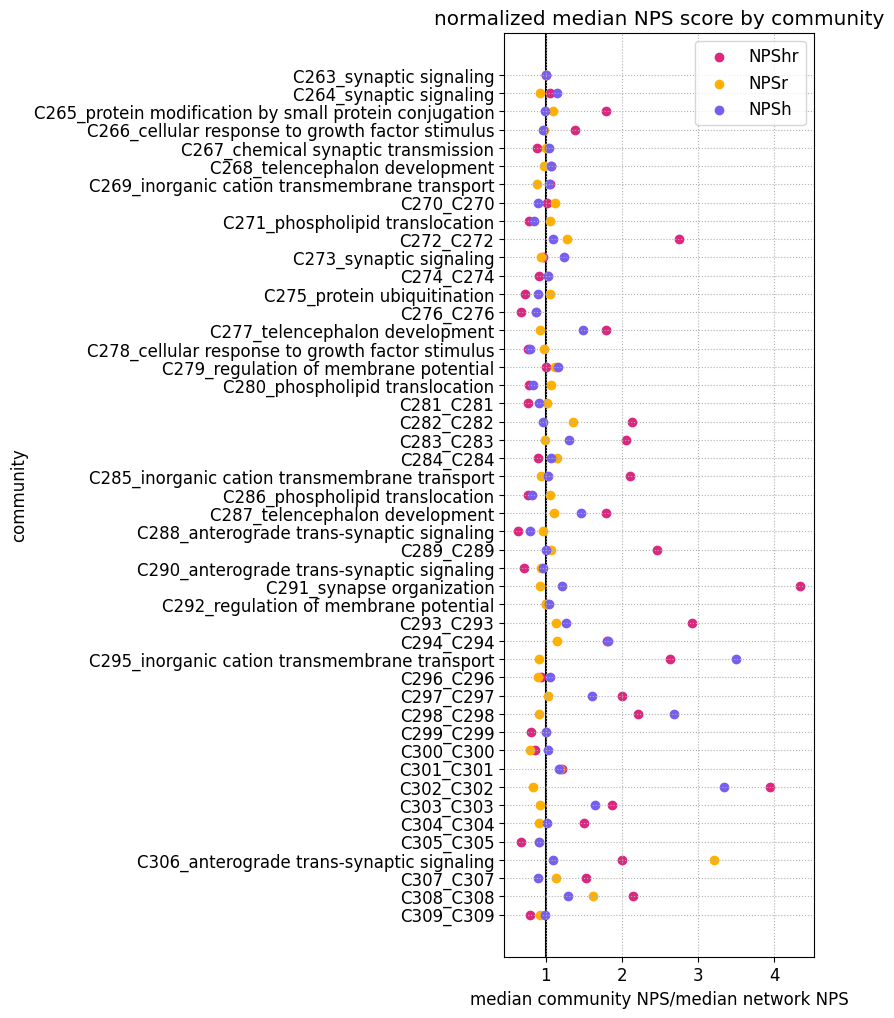

In [89]:
plt.figure(figsize=(4, 12))
plt.scatter(y=total_meta['merge'],x=total_meta.medhr_n,color=colour_dict['shared'],label='NPShr')
plt.scatter(y=total_meta['merge'],x=total_meta.medr_n,color=colour_dict[trait_r],label='NPSr')
plt.scatter(y=total_meta['merge'],x=total_meta.medh_n,color=colour_dict[trait_h],label='NPSh')

plt.ylabel('community')
#plt.xticks(rotation=90)
plt.xlabel('median community NPS/median network NPS')
plt.legend()
plt.grid(linestyle=':',zorder=0)
plt.axvline(x=1,color='black',zorder=0)
plt.title('normalized median NPS score by community')
plt.savefig(f'figures/normalized_median_NPS_all_communities_{name}.svg')

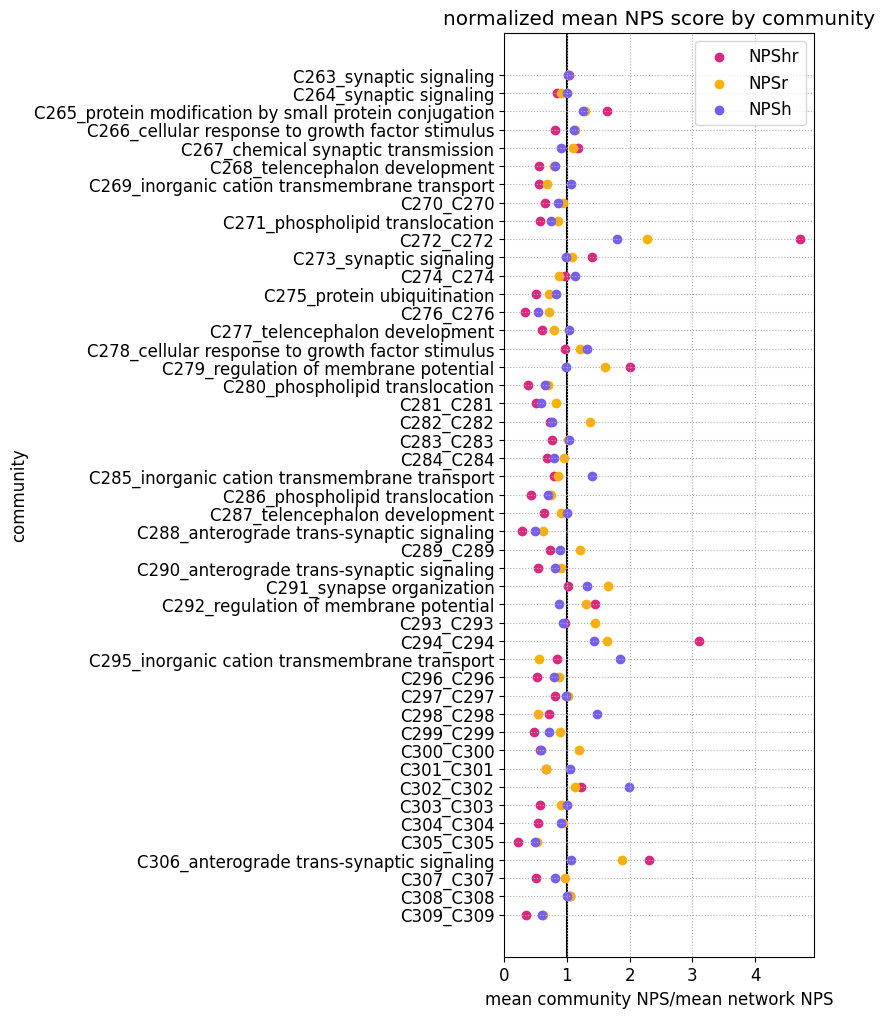

In [88]:
plt.figure(figsize=(4, 12))
plt.grid(linestyle=':')
plt.scatter(y=total_meta['merge'],x=total_meta.meanhr_n,color=colour_dict['shared'],label='NPShr')
plt.scatter(y=total_meta['merge'],x=total_meta.meanr_n,color=colour_dict[trait_r],label='NPSr')
plt.scatter(y=total_meta['merge'],x=total_meta.meanh_n,color=colour_dict[trait_h],label='NPSh')
plt.axvline(x=1,color='black',zorder=0)

plt.title('normalized mean NPS score by community')
plt.ylabel('community')
#plt.xticks(rotation=90)
plt.xlabel('mean community NPS/mean network NPS')
plt.legend()
plt.savefig(f'figures/normalized_mean_NPS_all_communities_{name}.svg')

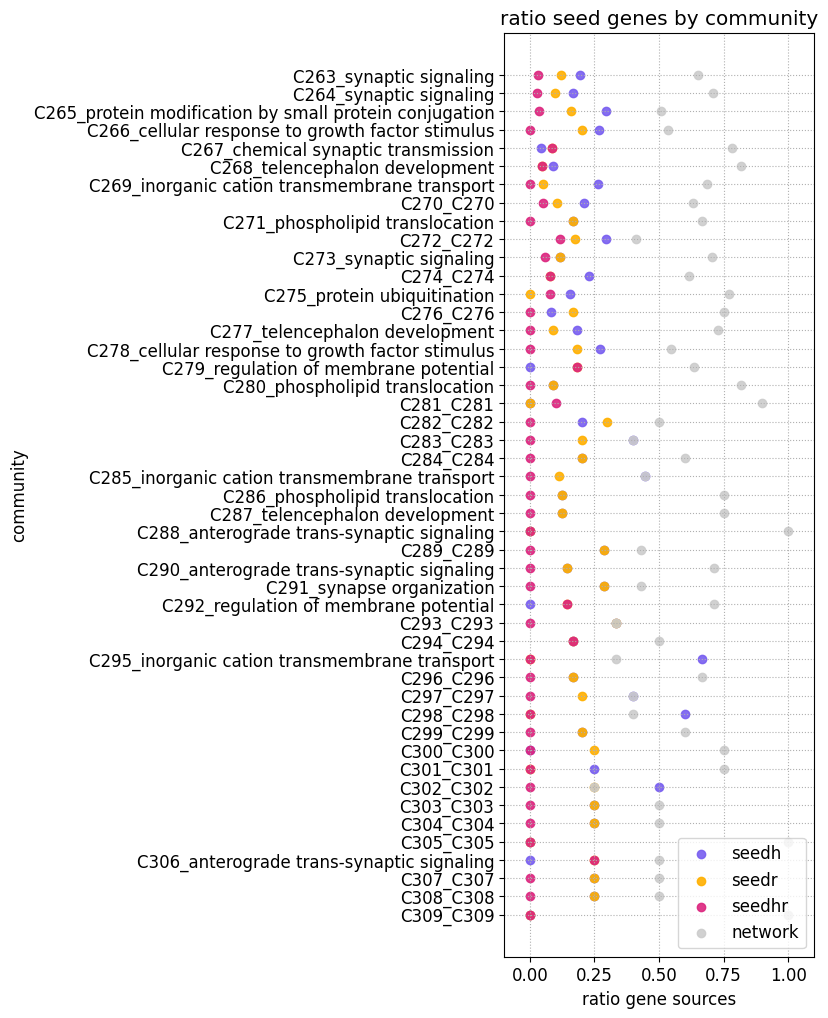

In [87]:
plt.figure(figsize=(4, 12))
plt.scatter(y=total_meta['merge'],x=total_meta.h_seed_ratio,color=colour_dict[trait_h],label='seedh',alpha=0.9)
plt.scatter(y=total_meta['merge'],x=total_meta.r_seed_ratio,color=colour_dict[trait_r],label='seedr',alpha=0.9)
plt.scatter(y=total_meta['merge'],x=total_meta.seed_hr_ratio,color=colour_dict['shared'],label='seedhr',alpha=0.9)
plt.scatter(y=total_meta['merge'],x=total_meta.network_ratio,color=colour_dict['other'],label='network',alpha=0.9)

plt.ylabel('community')
#plt.xticks([0,1,10])
plt.title('ratio seed genes by community')

plt.xlabel('ratio gene sources')
plt.legend()
plt.grid(linestyle=':',zorder=0)
#plt.axvline(x=1,color='black',zorder=0)
#plt.xscale('log')
plt.xlim([-.1,1.1])
plt.savefig(f'figures/ratio_seed_genes_all_communities_{name}.svg')


# merge imported systems map

In [61]:
if import_network:
    total_meta=hier_df.merge((nps_stats.merge(seed_fractions, left_index=True, right_index=True)), left_index=True, right_index=True)
    total_meta.to_csv(f"network_analysis/imported_{name}_{algorithm}_full_GO_enrichment_with_ratios.tsv",sep='\t')
    nps_stats.merge(seed_fractions, left_index=True, right_index=True).to_csv(f'network_analysis/imported_{name}_{algorithm}_ratios.tsv',sep='\t')

# plot figures imported systems map

In [63]:
total_meta=pd.read_csv('network_analysis/imported_loco_gsem_FDR_ext_top500_PCNet2.0_MAGMA_hidef_full_GO_enrichment_with_ratios.tsv',sep='\t',index_col=0)

In [18]:
plt.rcParams.update({'font.size': 16})

In [34]:
total_meta['merge']=total_meta.index+':'+total_meta.CD_CommunityName+' ('+total_meta.CD_MemberList_Size.astype(str)+')'

In [35]:
total_meta=total_meta.sort_values('merge',ascending=False)

## plot all communities

(0.4, 11)

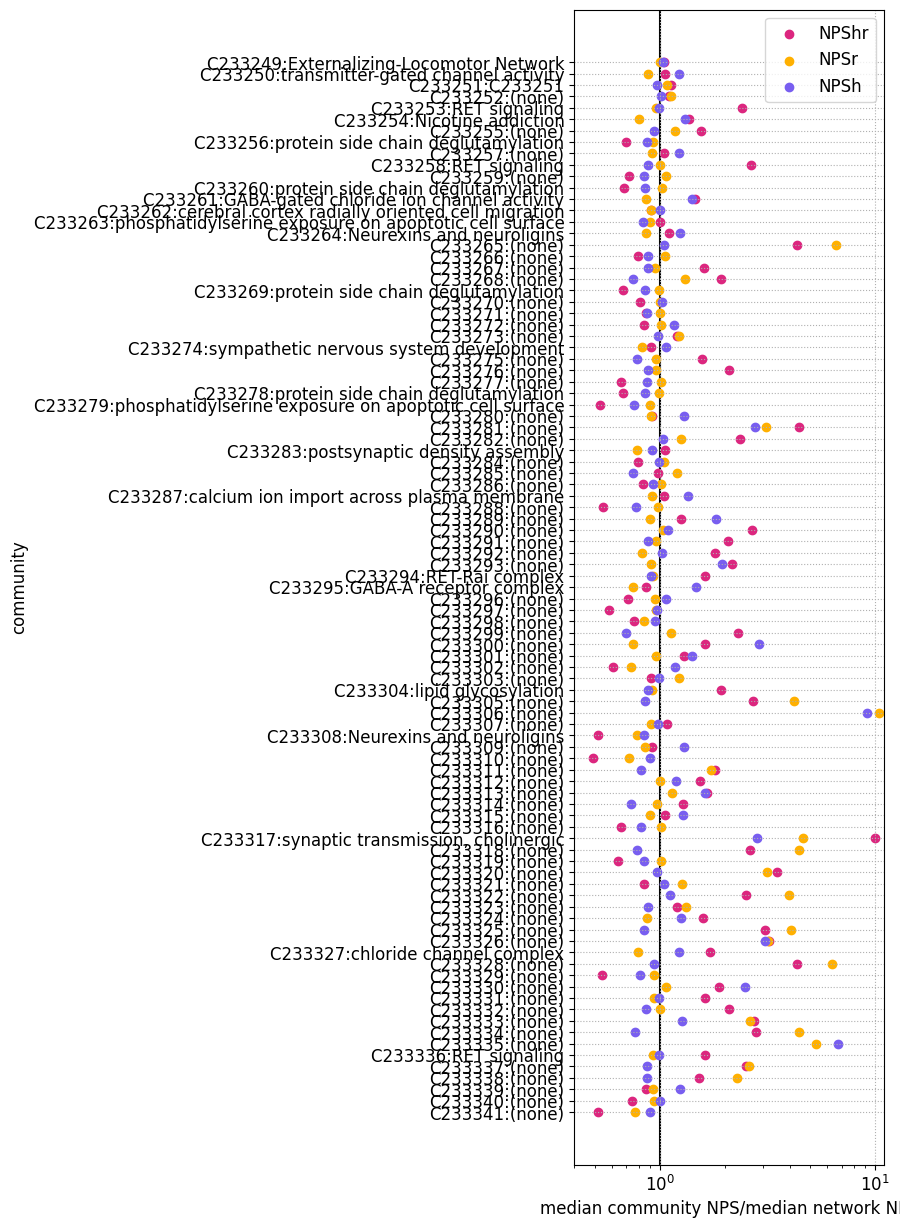

In [64]:
plt.figure(figsize=(4, 15))
plt.scatter(y=total_meta['merge'],x=total_meta.medhr_n,color=colour_dict['shared'],label='NPShr')
plt.scatter(y=total_meta['merge'],x=total_meta.medr_n,color=colour_dict[trait_r],label='NPSr')
plt.scatter(y=total_meta['merge'],x=total_meta.medh_n,color=colour_dict[trait_h],label='NPSh')

plt.ylabel('community')
#plt.xticks(rotation=90)
plt.xlabel('median community NPS/median network NPS')
plt.legend()
plt.grid(linestyle=':',zorder=0)
plt.axvline(x=1,color='black',zorder=0)
plt.xscale('log')
plt.xlim([0.4,11])

(0.4, 11)

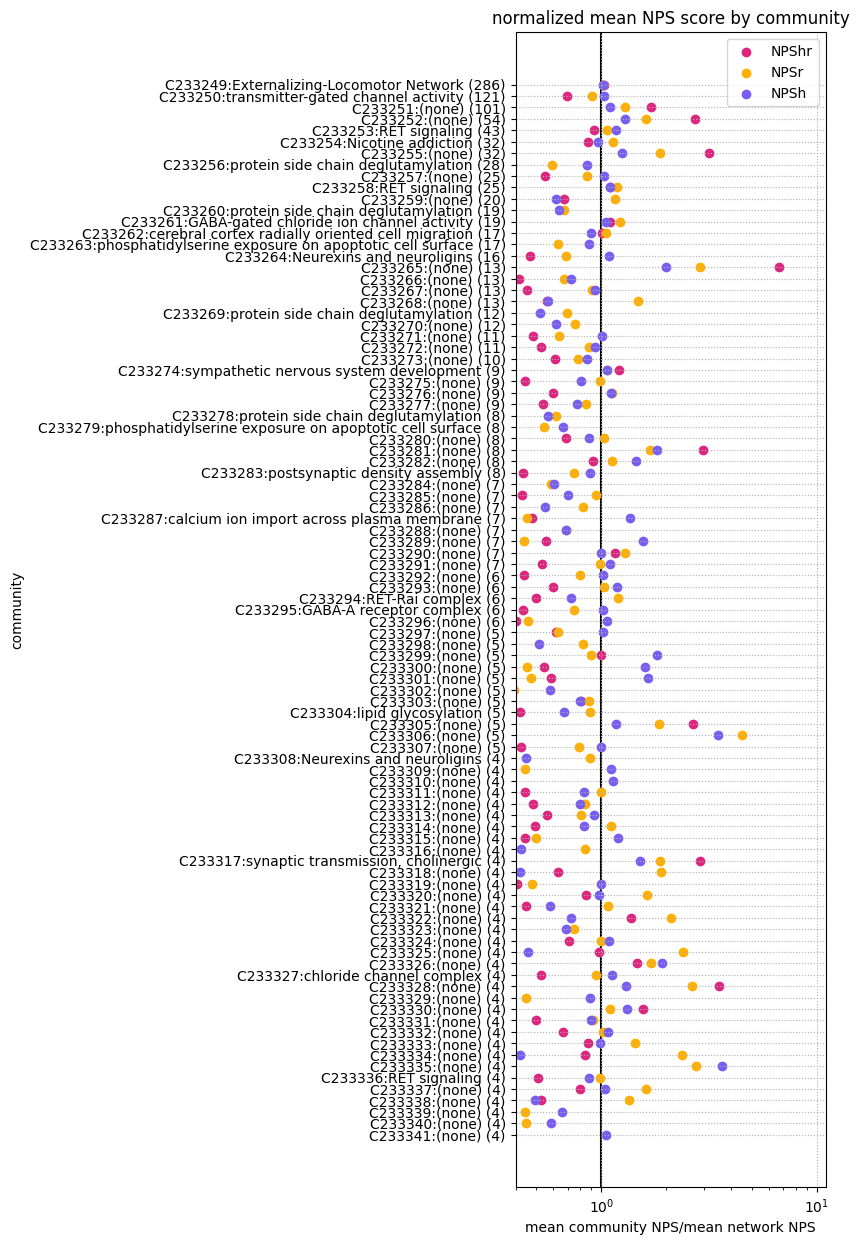

In [497]:
plt.figure(figsize=(4, 15))
plt.grid(linestyle=':')
plt.scatter(y=total_meta['merge'],x=total_meta.meanhr_n,color=colour_dict['shared'],label='NPShr')
plt.scatter(y=total_meta['merge'],x=total_meta.meanr_n,color=colour_dict[trait_r],label='NPSr')
plt.scatter(y=total_meta['merge'],x=total_meta.meanh_n,color=colour_dict[trait_h],label='NPSh')
plt.axvline(x=1,color='black',zorder=0)

plt.title('normalized mean NPS score by community')
plt.ylabel('community')
#plt.xticks(rotation=90)
plt.xlabel('mean community NPS/mean network NPS')
plt.legend()
plt.xscale('log')
plt.xlim([0.4,11])

(-0.1, 1.1)

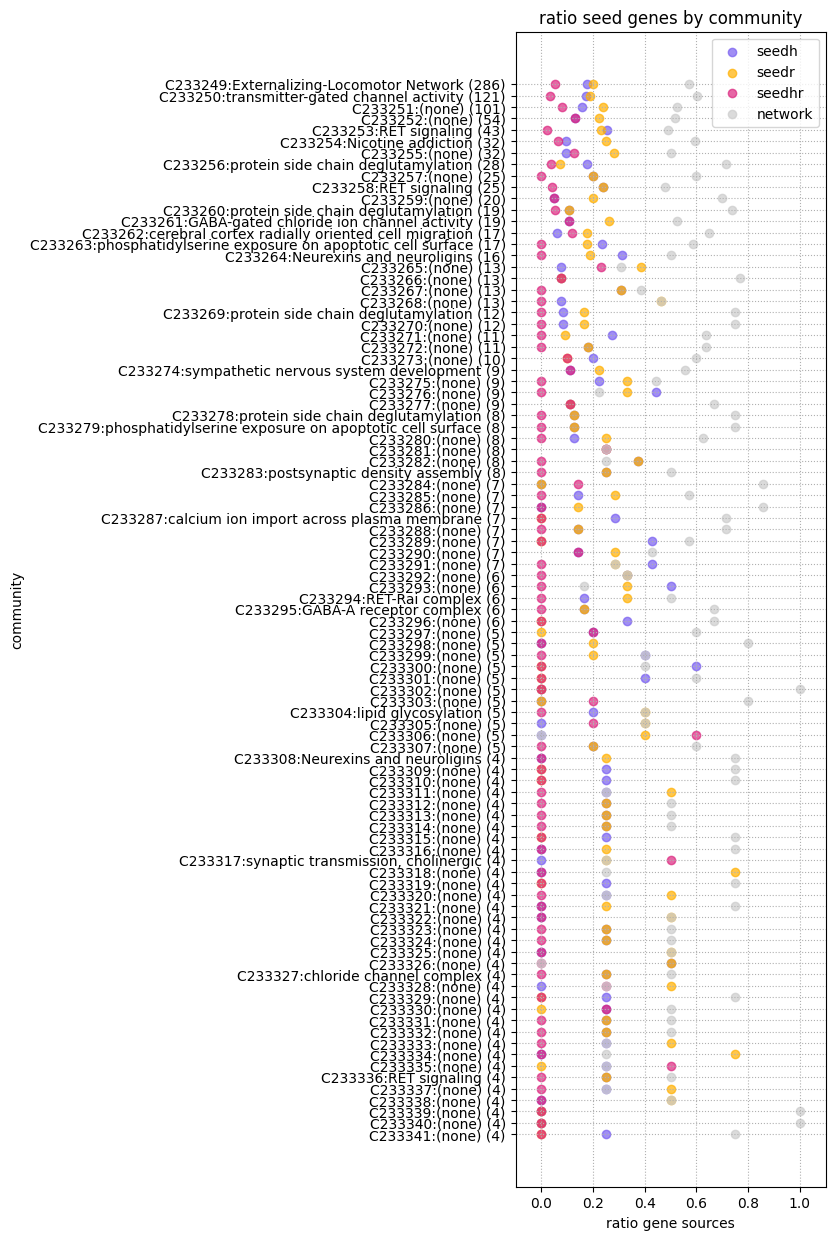

In [499]:
plt.figure(figsize=(4, 15))
plt.scatter(y=total_meta['merge'],x=total_meta.h_seed_ratio,color=colour_dict[trait_h],label='seedh',alpha=0.7)
plt.scatter(y=total_meta['merge'],x=total_meta.r_seed_ratio,color=colour_dict[trait_r],label='seedr',alpha=0.7)
plt.scatter(y=total_meta['merge'],x=total_meta.seed_hr_ratio,color=colour_dict['shared'],label='seedhr',alpha=0.7)
plt.scatter(y=total_meta['merge'],x=total_meta.network_ratio,color=colour_dict['other'],label='network',alpha=0.7)

plt.ylabel('community')
#plt.xticks([0,1,10])
plt.title('ratio seed genes by community')

plt.xlabel('ratio gene sources')
plt.legend()
plt.grid(linestyle=':',zorder=0)
#plt.axvline(x=1,color='black',zorder=0)
#plt.xscale('log')
plt.xlim([-.1,1.1])

## plot labelled communities

In [55]:
#if importing table from file
#t=total_meta[(total_meta.CD_Labeled==True)|(total_meta.index=='C233251')|(total_meta.index=='C233257')]

In [48]:
t=total_meta[(total_meta.CD_Labeled=='True')|(total_meta.index=='C233251')|(total_meta.index=='C233257')]

In [56]:
t.at['C233257','merge']='C233257 ('+t.CD_MemberList_Size['C233257'].astype(str)+')'
t.at['C233251','merge']='C233251 ('+t.CD_MemberList_Size['C233251'].astype(str)+')'

In [57]:
t=t.sort_values('CD_CommunityName',ascending=False)

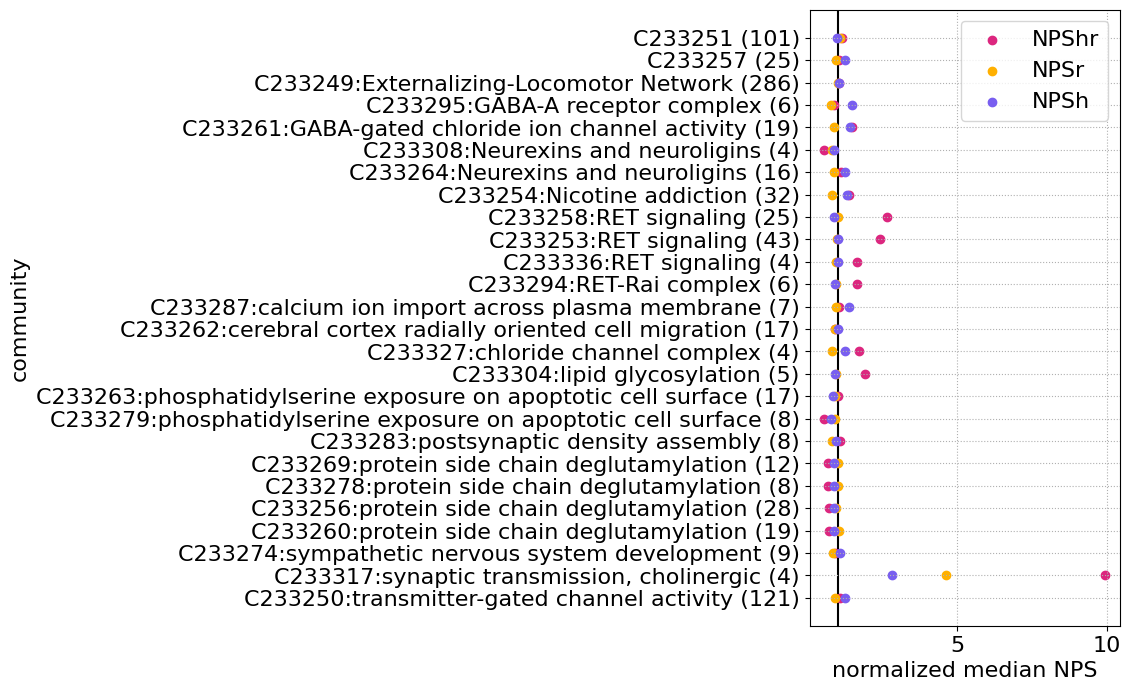

In [63]:
plt.figure(figsize=(4, 8))
plt.scatter(y=t['merge'],x=t.medhr_n,color=colour_dict['shared'],label='NPShr')
plt.scatter(y=t['merge'],x=t.medr_n,color=colour_dict[trait_r],label='NPSr')
plt.scatter(y=t['merge'],x=t.medh_n,color=colour_dict[trait_h],label='NPSh')

plt.ylabel('community')
#plt.xticks([0,1,10])
#plt.title('normalized median NPS score by community')

#plt.xlabel('median community NPS/median network NPS')
plt.xlabel('normalized median NPS')
plt.legend()
plt.grid(linestyle=':',zorder=0)
plt.axvline(x=1,color='black',zorder=0)
#plt.xscale('log')
#plt.xlim([0.5,11])

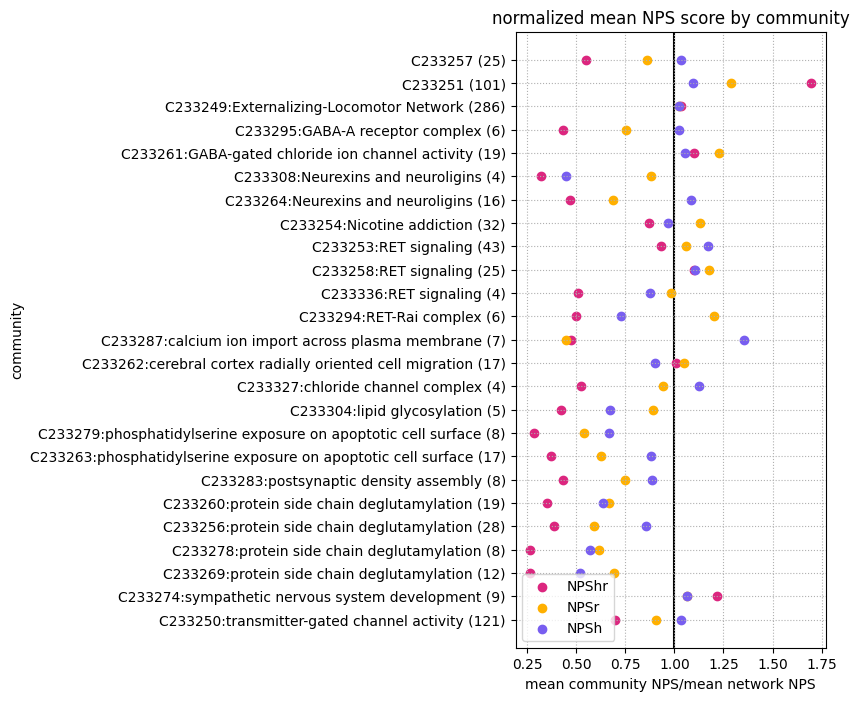

In [504]:
plt.figure(figsize=(4, 8))
plt.grid(linestyle=':')
plt.scatter(y=t['merge'],x=t.meanhr_n,color=colour_dict['shared'],label='NPShr')
plt.scatter(y=t['merge'],x=t.meanr_n,color=colour_dict[trait_r],label='NPSr')
plt.scatter(y=t['merge'],x=t.meanh_n,color=colour_dict[trait_h],label='NPSh')
plt.axvline(x=1,color='black',zorder=0)

plt.title('normalized mean NPS score by community')
plt.ylabel('community')
#plt.xticks(rotation=90)
plt.xlabel('mean community NPS/mean network NPS')
plt.legend()
#plt.xscale('log')
#plt.xlim([0.4,11])

(-0.1, 1.1)

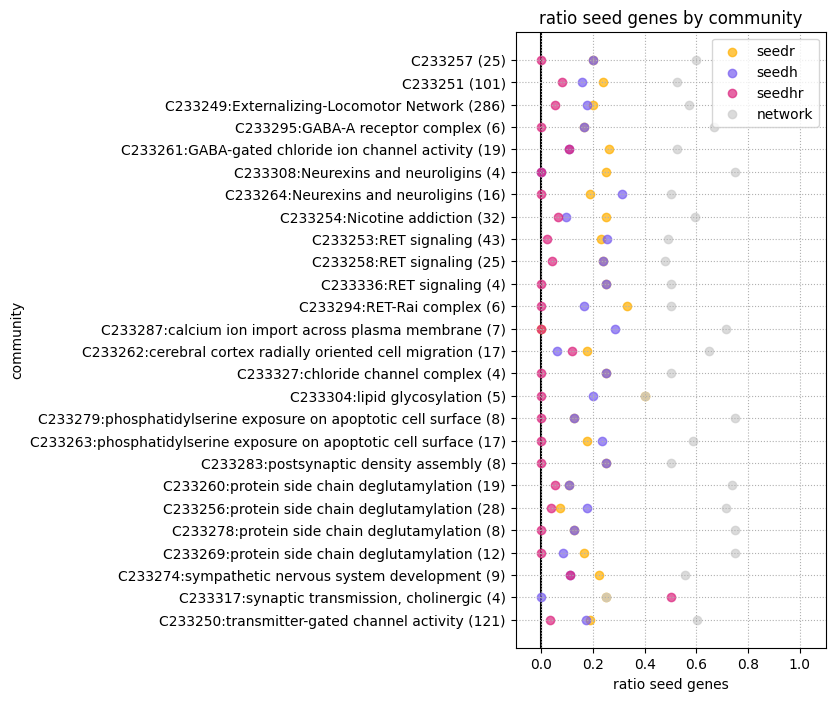

In [490]:
plt.figure(figsize=(4, 8))
plt.scatter(y=t['merge'],x=t.r_seed_ratio,color=colour_dict[trait_r],label='seedr',alpha=.7)
plt.scatter(y=t['merge'],x=t.h_seed_ratio,color=colour_dict[trait_h],label='seedh',alpha=.7)
plt.scatter(y=t['merge'],x=t.seed_hr_ratio,color=colour_dict['shared'],label='seedhr',alpha=.7)
plt.scatter(y=t['merge'],x=t.network_ratio,color=colour_dict['other'],label='network',alpha=.7)

plt.ylabel('community')
#plt.xticks([0,1,10])
plt.title('ratio seed genes by community')

plt.xlabel('ratio seed genes')
plt.legend()
plt.grid(linestyle=':',zorder=0)
plt.axvline(x=0,color='black',zorder=0)
#plt.xscale('log')
plt.xlim([-.1,1.1])

# Check MGI enrichment for communities

## import MGI datasets

In [44]:
# load mappings between genes and mammalian phenotypes
mgi_df = validation.load_MGI_mouseKO_data()
print("Number of gene-phenotype associations:", len(mgi_df))
# import table of names of MPO terms
MPO_desc=import_MPO_description()
#import the MPO in graph format
graph = obo.read_obo('http://www.informatics.jax.org/downloads/reports/MPheno_OBO.ontology')
#subset the graph to remove obsolete terms
graph=graph.subgraph(list(set(MPO_desc[~MPO_desc['description'].str.contains('obsolete')].index)))
#get id from name or name from ID 
id_to_name = {id_: data.get('name') for id_, data in graph.nodes(data=True)}
name_to_id = {data['name']: id_ for id_, data in graph.nodes(data=True) if 'name' in data}

33 input query terms found dup hits:	[('Adam1a', 2), ('Betalinc1', 2), ('Cast', 2), ('Chaserr', 2), ('Dnajb3', 2), ('Dnm3os', 2), ('Eldr'
12723 input query terms found no hit:	['+|Cav1', '+|Cm', '+|Del(10Prmt2-Pdxk)4Yey', '+|Del(11Mpo-Chad)18Brd', '+|Del(11Rr325)1Smun', '+|De


25820
13097
13064
Number of gene-phenotype associations: 384558


/tscc/projects/ps-palmer/brittany/ddot/ddot/Ontology.py:394: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series(id2namespace).to_csv(id2namespace_file, sep='\t')


15453


In [45]:
par=[id_to_name[x] for x in graph.predecessors('MP:0000001')]

In [46]:
gpt_path='validation_datasets/MGI_genes_per_trait_MP.csv'
if (os.path.isfile(gpt_path)):
    genes_per_trait=pd.read_csv(gpt_path)
    print('reading in file')
else:
    print('calculating genes per trait')
    genes_per_trait=count_genes_per_trait(['MP:0000001'],mgi_df,'human_ortholog','MP',id_to_name,name_to_id,graph)
    genes_per_trait.to_csv(gpt_path,index=False)

reading in file


In [50]:
#get rest of datasets based on what was specified above
coloc_dict=def_coloc_dict(seed_r,seed_h,NPS,all_nodes,cut_single,cut_comb,cut_rat_specific,cut_hm_specific)
val_lab_dict=def_val_label_dict(label_h,label_r,interactome_name,cut_single,cut_comb)

In [67]:
MPO_desc

,description
MP,
MP:0000001,mammalian phenotype
MP:0000002,obsolete Morphology
MP:0000003,abnormal adipose tissue morphology
MP:0000011,abnormal adipose tissue morphology
MP:0000005,increased brown adipose tissue amount
...,...
MP:3000003,abnormal Ebner's gland morphology
MP:3000004,abnormal nictitating membrane morphology
MP:3000005,abnormal lacrimal sac morphology


In [60]:
netval=pd.read_csv(f'validation_output/MGI_enr_{val_lab_dict["net"]}_enr.csv')

In [71]:
coloc_dict_cat

NameError: name 'coloc_dict_cat' is not defined

In [63]:
netval[netval.p_intersect<0.05]

,trait,parent_trait,network_genes,odds_ratio,log_se_or,p_intersect,depth,seed_h,seed_r,n_seed_h,n_seed_r,n_seed
9,behavior/neurological phenotype,mammalian phenotype,"{'DGKI', 'NAGS', 'STAU1', 'VAMP2', 'GLRB', 'CH...",2.022115,0.131520,4.794891e-08,0,set(),set(),0,0,0
24,nervous system phenotype,mammalian phenotype,"{'STAU1', 'TBATA', 'VAMP2', 'GLRB', 'CHRNA4', ...",2.722017,0.131053,1.668203e-14,0,set(),set(),0,0,0
25,normal phenotype,mammalian phenotype,"{'CALB2', 'CAMTA1', 'VAMP2', 'CACNG3', 'UBTF',...",1.337383,0.159538,4.378585e-02,0,set(),set(),0,0,0
44,no abnormal phenotype detected,normal phenotype,"{'CALB2', 'CAMTA1', 'VAMP2', 'CACNG3', 'UBTF',...",1.339830,0.159540,4.279260e-02,1,set(),set(),0,0,0
73,abnormal muscle physiology,muscle phenotype,"{'ASIC2', 'CHRNE', 'TFAP2B', 'RPS6KB1', 'VPS54...",1.472243,0.200669,3.892472e-02,1,set(),set(),0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
6342,absent hippocampus CA3 region,abnormal hippocampus CA3 region morphology,{'EMX1'},49.112033,1.415710,3.966978e-02,10,set(),set(),0,0,0
6350,disorganized barrel cortex,abnormal barrel cortex morphology,"{'GAP43', 'GRIN2B'}",19.720000,0.839197,7.855243e-03,10,set(),set(),0,0,0
6353,decreased hippocampus volume,small hippocampus,"{'ZDHHC17', 'FOXG1'}",9.855833,0.777336,2.311302e-02,10,set(),set(),0,0,0
6377,absent hippocampus CA1 region,abnormal hippocampus CA1 region morphology,{'EMX1'},inf,NaN,2.003477e-02,10,set(),set(),0,0,0


In [ ]:
if run_analysis:
    tbl=recurse_enrichment(par,graph,id_to_name, 
        name_to_id,'mammalian phenotype',mgi_df,'MP','human_ortholog',
        coloc_dict_cat,sub_community,
        whole_community,outpath,depth=0,depth_term=None,verbose=False,enr_concat=None)
    tbl.to_csv(outpath,index=False)
    print(f'table saved as {outpath}')

In [ ]:
def recurse_enrichment(par,graph,id_to_name, name_to_id,heirarchy_name,graph_df,term_col,gene_col,coloc_dict_cat,sub_community,whole_community,outpath=None,depth=0,depth_term=None,verbose=False,enr_concat=None):
    '''
    par- list of starting parent traits
    graph- graph structure of the network
    id_to_name- dictionary that transforms names to ID#s
    name_to_id- dictionary that transforms IDs to names
    heirarchy_name- string- name of the heirarchical structure
    graph_df- dataframe of the graph that shows relationship between trait and gene
    term_col- string- column of dataframe that has the term names of the communities in the heriarchy. For MGI it's 'MP' for GWAS catalog it's 'EFO_term'
    gene_col- string- column of dataframe that has the human gene names. For MGI it's 'human_ortholog', for GWAS catalog it's 'GENE'
    coloc_dict_cat- dictionary of genesets (sourced from coloc_dict) that are annoated in graph
    sub_community- string- community you're testing enrichment for. should be a key in coloc_dict_cat
    whole_community- string- community you're testing enrichment against. should be a key in coloc_dict_cat
    outpath- string- path to where the file is saved
    depth- int- variable that tracks what depth of the heirarchical structure you are in
    depth_term- int- overwrite depth to terminate at. Use None unless you want to terminate early. You will probably want to terminate early for EFO recommend depth_term=5.
    verbose- string- determines whether to print the enrichments as they are calculated
    enr_concat- dataframe- initially pass None 

    returns: dataframe-enr_concat
    '''
    if depth==None:
        depth=0
    enr_tbl=pd.DataFrame(columns=['trait','parent_trait','community_genes','odds_ratio','log_se_or','p_intersect','depth'])

    print(f"analyzing structure depth={depth}")
    '''
    this code was written like this for the following reason- If you just started with the top of the heirarchy's single trait
    this would be unnecessary- HOWEVER, I wanted to be able to input a starting list of parent terms, as opposed to a singular term, mostly because of the EFO.
    so this takes the list of parent terms- then after that it goes through the structure following the standard way. 
    if you did it the other way, you would just want to use the else statement part of this code.
    '''
    if (depth==0):        
        for p in par:
            #get all children terms
            children=return_descendents_name(graph,id_to_name, name_to_id[p])
            #get all genes annotated for children terms 
            t=set(graph_df[graph_df[term_col].isin([name_to_id[x] for x in children])][gene_col].dropna())
            odds_ratio, log_se_or, p_intersect, gene_list= calculate_enrichment(t,coloc_dict_cat,p,sub_community,whole_community,verbose)
            if (len(gene_list)>0):
                enr_tbl = pd.concat([pd.DataFrame([[p, heirarchy_name, gene_list, odds_ratio, log_se_or, p_intersect,depth]], columns=enr_tbl.columns), enr_tbl], ignore_index=True)
                enr_tbl['depth']=depth
                if len(enr_tbl)>0:
                    enr_tbl.to_csv(outpath,index=False)

    else:
       for p in par:
            #select parent term
            #get all children terms (not all descendents, just first level children)- loop over
            for c in list(map(lambda x: id_to_name[x],list(graph.predecessors(name_to_id[p])))):
                # get all grand children- use all terms as subterm
                children=return_descendents_name(graph,id_to_name, name_to_id[c])
                t=set(graph_df[graph_df[term_col].isin([name_to_id[x] for x in children])][gene_col].dropna())
                odds_ratio, log_se_or, p_intersect, gene_list= calculate_enrichment(t,coloc_dict_cat,c,sub_community,whole_community,verbose)
                if (len(gene_list)>0):
                    enr_tbl = pd.concat([pd.DataFrame([[c, p, gene_list, odds_ratio, log_se_or, p_intersect,depth]], columns=enr_tbl.columns), enr_tbl], ignore_index=True)
                    enr_tbl['depth']=depth
                if len(enr_tbl)>0:
                    enr_tbl.to_csv(outpath,index=False,header=False,mode='a')
             
    children=set(enr_tbl['trait'])
    if enr_concat is None:
        enr_concat = pd.DataFrame(columns=['trait', 'parent_trait', 'community_genes', 'odds_ratio', 'log_se_or', 'p_intersect', 'depth'])
    if not (enr_tbl.empty):
        enr_concat = pd.concat([enr_concat, enr_tbl])
    
    print(f"\tlength of enrichment table={len(enr_tbl)}")
    print(f"\tlength of concatenated enrichment table={len(enr_concat)}")
    print(f"\tlength of children={len(children)}")
    if (depth==depth_term):
        print('reached overwritten depth-returning concatenated enrichment table')
        print(enr_concat.head())
        return enr_concat
    else:
        if (len(children)!=0):
            return recurse_enrichment(children,graph,id_to_name, name_to_id,heirarchy_name,graph_df,term_col,gene_col,coloc_dict_cat,sub_community,whole_community,outpath,depth+1,depth_term,verbose,enr_concat)
        else:
            print('returning concatenated enrichment table')
            print(enr_concat.head())
            return enr_concat

In [ ]:
def return_descendents_name(graph,id_to_name, term):
	#return list set of traits in  ontology including parent- reported by name
	#modified from DDOT example
    l=list(sorted(id_to_name[subterm] for subterm in nx.ancestors(graph, term))) #descendents get subterms- not sure why but I tested it and OBONET says so as well
    l.append(id_to_name[term])
    return list(set(l))

def return_ancestors_name(graph,id_to_name, term):
	#return list set of traits in  ontology including parent- reported by name
	#modified from DDOT example
    print('getting ancestors for '+term+' : '+id_to_name[term])
    l=list((id_to_name[supterm] for supterm in nx.descendants(graph, term))) #descendents get superterms- not sure why
    #l.append(id_to_name[term])
    return list(set(l))

In [ ]:
def community_term_enrichment(community_name, hier_df, MPO, mgi_df, term_counts, gene_to_terms, G_int, keep_genes=None, exclude_genes=None):
    """Takes a community and tests the genes in this community for enrichment of genes associated with phenotypes in MGI

    Args:
        community_name (str): Index of the community to test
        hier_df (:py:class:`pandas.DataFrame`): Dataframe containing the genes in each community as produced by HiDeF
        MPO (:py:class:`ddot.Ontology`): Mammalian phenotype ontology with gene mappings from MGI
        mgi_df (:py:class:`pandas.DataFrame`): Gene phenotype mapping
        term_counts (dict): Number of genes associated with each term, produced by :py:func:`genes_per_node`
        gene_to_terms (dict): Number of terms associated with each gene, produced by :py:func:`genes_per_node`
        G_int (networkx.Graph): The molecular interaction network
        keep_genes (list, optional): List of genes to only include from the analysis. Defaults to None.
        exclude_genes (list, optional): List of genes to exclude from the analysis. Defaults to None.

    Returns:
        :py:class:`pandas.DataFrame`: The enrichment statistics for `community` for all terms in MPO
    """
    # get the genes in the community
    genes = hier_df.loc[community_name, "CD_MemberList"]
    if type(genes) is str:  # split into a list of genes
        genes_all = genes.split(" ")
        N_hier = len(genes_all)
    else:
        genes_all = genes
        N_hier = len(genes_all)
    # only keep genes in the MGI ontology    
    genes = [ g for g in genes_all if g in MPO.genes ]  
    
    # subset genes based on input
    if keep_genes is not None:
        genes = [g for g in genes if g in keep_genes]
        N_hier = len([g for g in genes_all if g in keep_genes])
    if exclude_genes is not None:
        genes = [g for g in genes if g not in exclude_genes]
        N_hier = len([g for g in genes_all if g not in exclude_genes])
    
    # exit if there are no genes remaining
    if len(genes) == 0:
        print("0/"+str(len(genes_all)), "in MPO.genes/seeds")
        return pd.DataFrame()
    
    # Get the terms associated with these genes
    terms = []
    for gene in genes:
        terms += list(gene_to_terms[MPO.genes.index(gene)])

    # Join term totals and observed
    to_test = pd.DataFrame(pd.Series(terms, name="observed").value_counts()).join(pd.Series(term_counts, name="total"))
    M_pool_size = len(G_int.nodes())
    
    # Get odss ratio, p value of odds ratio, and 95% confidence interval
    OR_test = to_test.apply(lambda x: get_contingency_stats(x.observed, x.total, N_hier, M_pool_size), axis=1)
    try: 
        OR_test = pd.concat(list(OR_test), ignore_index=True)
    except TypeError:
        print(OR_test)
        print(N_hier, terms)
    OR_test.index = to_test.index
    to_test = pd.concat([to_test, OR_test], axis=1)
    
    to_test = to_test.assign(hyper_p=lambda z: hypergeom.sf(k=z.observed, M=M_pool_size, n=z.total, N=N_hier))
    desc = MPO.node_attr.loc[to_test.index]
    to_test = to_test.assign(sig_5e6=to_test["hyper_p"] < 5e-6)
    to_test = to_test.join(desc, how="left")
    to_test = to_test.assign(size=N_hier)
    return to_test

In [ ]:
def get_contingency_stats(observed, term_size, community_size, network_size):
    """Calculates enrichment statistics for the number of genes associated with a term using a chi-squared test.

    Args:
        observed (int): The number of community genes associated with a term
        term_size (int): The total number of genes associated with a term
        community_size (int): The total number of genes in a community
        network_size (int): The gobal network size

    Returns:
        :py:class:`pandas.DataFrame`: The odds ratio, p value and confidence interval for observed enrichment
    """
    q00 = observed
    q01 = term_size - observed
    q10 = community_size - observed
    q11 = network_size - q00 - q01 - q10
    results_table = [[q00, q01], [q10, q11]]
    CT = contingency_tables.Table2x2(results_table)
    OR_p_temp = CT.oddsratio_pvalue()
    OR_CI_temp = CT.oddsratio_confint()
    OR = CT.oddsratio

    return pd.DataFrame({"OR":OR, "OR_p": OR_p_temp, "OR_CI_lower":OR_CI_temp[0], "OR_CI_upper":OR_CI_temp[1]}, index=[0])


In [ ]:
q00 = observed
q01 = term_size - observed
q10 = community_size - observed
q11 = network_size - q00 - q01 - q10


In [ ]:
def calculate_enrichment(t, coloc_dict_cat, k, sub='net', total='graph', verbose=True):
    # modified from rare_common_alcohol
    # Calculate enrichment for a group of genes (sub) versus all in larger group (total)
    # Calculate values for the contingency table
    M = len(coloc_dict_cat[total])  # Population size: genes in PCNet annotated in the GWAS catalog
    n = len(coloc_dict_cat[total].intersection(t))  # Genes in PCNet annotated for the trait of interest
    N = len(coloc_dict_cat[sub])  # Genes in the network annotated in the GWAS catalog
    x = len(coloc_dict_cat[sub].intersection(t))  # Genes in network annotated for the trait of interest

    # Build contingency table
    contingency_table = [
        [x, N - x],
        [n - x, M - N - (n - x)]
    ]
    
    # Perform Fisher's exact test
    odds_ratio, p_intersect = stats.fisher_exact(contingency_table, alternative='greater')
    gene_list = t.intersection(coloc_dict_cat[sub])
    
    OR_p_temp = contingency_table.oddsratio_pvalue()
    OR_CI_temp = contingency_table.oddsratio_confint()
    OR = contingency_table.oddsratio

    try:
        se = np.sqrt(1/x + 1/(N-x) + 1/(n-x) + 1/(M - N - (n - x)))
    except ZeroDivisionError:
        se = None
    
    # Create the results dictionary
    if verbose:
        print(f"Enrichment of network nodes in genes in the GWAS catalog annotated for {k}: p={p_intersect}")
        p_value_hypergeom = stats.hypergeom.sf(x-1, M, n, N)
        print(f'Enrichment calculated using hypergeom.sf for {k}: p={p_value_hypergeom}, p_contingency_table={OR_p_temp}')
        print(f"Odds ratio: OD={odds_ratio}, via_contingency OR={OR}")
        print(f"Number of annotated genes in {total}: {len(t.intersection(coloc_dict_cat[total]))}")
        print(f"Number of annotated genes in {sub}: {len(t.intersection(coloc_dict_cat[sub]))}\n")   
    return odds_ratio, se, p_intersect, gene_list
